In [1]:
%matplotlib inline
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

# staker payout playground

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10, 8)})

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import binom
pd.options.mode.chained_assignment = None 

import json

In [4]:
from MinaClient import Client
from mina_schema import mina_explorer_schema
from sgqlc.operation import Operation

MINA_EXPLORER_ENDPOINT = "https://graphql.minaexplorer.com/"
mina_explorer_client = Client(endpoint=MINA_EXPLORER_ENDPOINT)

In [5]:
FOUNDATION_DELEGATION_ADDRESSES = [
    "B62qmsYXFNNE565yv7bEMPsPnpRCsMErf7J2v5jMnuKQ1jgwZS8BzXS",
    "B62qn71s63yywMUCcFhP4iCata7HpgyrvmGjpKa1D9544vGW6FBZ6a1",
    "B62qqEV4oP7w2jLQGckvZzdWjfdLKySKHJ3tNU5niRjpPD7beYumWTB",
    "B62qmQAFPta1Q3c7wXHxXRKnE3uWyBYZCLb8frdHEgavi3BbBVkpeC1"
] 

STAKER_PUBLIC_KEY = "B62qpge4uMq4Vv5Rvc8Gw9qSquUYd6xoW1pz7HQkMSHm6h1o7pvLPAN" # mina explorer
STAKER_FEE = 0.05 
STAKER_FOUNDATION_FEE = 0.05 

LEDGER_HASH = "jx7buQVWFLsXTtzRgSxbYcT8EYLS8KCZbLrfDcJxMtyy4thw2Ee"

## get stakers

In [6]:
op = Operation(mina_explorer_schema.Query)

query = mina_explorer_schema.StakeQueryInput(
    delegate=STAKER_PUBLIC_KEY, ledger_hash=LEDGER_HASH
)

stakes = op.stakes(query=query, limit=1000)

stakes.public_key()
stakes.balance()
stakes.timing.timed_weighting()

res = mina_explorer_client.send_any_query(op)

stakes_df = pd.json_normalize(res["data"]["stakes"], sep="_")

using: https://graphql.minaexplorer.com/


In [7]:
stakes_df["is_foundation_delegation"] = stakes_df.public_key.isin(
    FOUNDATION_DELEGATION_ADDRESSES
)
stakes_df.timing_timed_weighting.fillna(1, inplace=True)

In [8]:
total_staking_balance_foundation = stakes_df[
    stakes_df.is_foundation_delegation
].balance.sum()

total_staking_balance = stakes_df.balance.sum()

print(f"total_staking_balance: {total_staking_balance}")
print(f"total_staking_balance_foundation: {total_staking_balance_foundation}")
print(f"delegates: {stakes_df.shape[0]}")

total_staking_balance: 10883171.794181166
total_staking_balance_foundation: 3705636.6277516503
delegates: 110


# get blocks

In [35]:
epoch = 0
block_height_gte = 0
block_height_lte = 5075

consensus_state = mina_explorer_schema.BlockProtocolStateConsensusStateQueryInput(
    epoch=epoch
)
protocol_state = mina_explorer_schema.BlockProtocolStateQueryInput(
    consensus_state=consensus_state
)

op = Operation(mina_explorer_schema.Query)

query = mina_explorer_schema.BlockQueryInput(
    block_height_gte=block_height_gte,
    block_height_lte=block_height_lte,
    creator=STAKER_PUBLIC_KEY,
    protocol_state=protocol_state,
)

blocks = op.blocks(
    query=query,
    limit=500,
)

blocks.transactions()
blocks.block_height()
blocks.canonical()
blocks.tx_fees()
blocks.snark_fees()
blocks.state_hash()
blocks.date_time()
blocks.protocol_state.consensus_state.total_currency()
    
res = mina_explorer_client.send_any_query(op)

blocks_df = pd.json_normalize(res['data']['blocks'], sep='_')


using: https://graphql.minaexplorer.com/


In [34]:
# keep the non canonical blocks for later analysis
blocks_df.canonical.value_counts()

True     86
False    64
Name: canonical, dtype: int64

In [11]:
# keep only the canonical blocks
df = blocks_df[blocks_df.canonical == True]

df.dateTime = pd.to_datetime(df.dateTime)
df.transactions_coinbase = df.transactions_coinbase.astype(int)
df.txFees = df.txFees.astype(int)
df.snarkFees = df.snarkFees.astype(int)

In [12]:
df.head()

,blockHeight,canonical,dateTime,snarkFees,stateHash,txFees,protocolState_consensusState_totalCurrency,transactions_coinbase,transactions_coinbaseReceiverAccount_publicKey,transactions_feeTransfer,transactions_userCommands
0,5044,True,2021-03-31 19:00:00+00:00,0,3NKwM2qNH3mHJUnVW7ceDD1vZmRwu6JRxh3yS9KURv84LS...,30000000,808924492840039300,720000000000,B62qk9WYHu2PBYv4EyEubnVQURcwpiV2ysuYYoMdwi8YTn...,"[{'fee': '30000000', 'recipient': 'B62qk9WYHu2...","[{'amount': 1000, 'blockHeight': 5044, 'blockS..."
3,4933,True,2021-03-31 11:15:00+00:00,0,3NLsUwqgg9wLgs2jPt4fc7C6nCFVcwV2fEtUvBgayJ1Pj8...,20000000,808772572840039300,720000000000,B62qk9WYHu2PBYv4EyEubnVQURcwpiV2ysuYYoMdwi8YTn...,"[{'fee': '20000000', 'recipient': 'B62qk9WYHu2...","[{'amount': 1000, 'blockHeight': 4933, 'blockS..."
4,4863,True,2021-03-31 06:18:00+00:00,0,3NLxWu1srPkcm5oaSDg6Bv6rTfeRiDToZHRs36AfP5weXQ...,31000000,808684732840039300,720000000000,B62qk9WYHu2PBYv4EyEubnVQURcwpiV2ysuYYoMdwi8YTn...,"[{'fee': '31000000', 'recipient': 'B62qk9WYHu2...","[{'amount': 0, 'blockHeight': 4863, 'blockStat..."
11,4666,True,2021-03-30 16:30:00+00:00,0,3NKAPj9zPTvy17i7uQ9ePGp9U377A4divJf2Qiu5dr2SQ3...,40000000,808451452840039300,720000000000,B62qk9WYHu2PBYv4EyEubnVQURcwpiV2ysuYYoMdwi8YTn...,"[{'fee': '40000000', 'recipient': 'B62qk9WYHu2...","[{'amount': 1000, 'blockHeight': 4666, 'blockS..."
12,4594,True,2021-03-30 11:18:00+00:00,0,3NKu4jk4AaCF1V9JJDGjMsPpAHYpUX37YosHSg6pLBrGjt...,20000000,808390252840039300,720000000000,B62qk9WYHu2PBYv4EyEubnVQURcwpiV2ysuYYoMdwi8YTn...,"[{'fee': '20000000', 'recipient': 'B62qk9WYHu2...","[{'amount': 1000, 'blockHeight': 4594, 'blockS..."


In [13]:
# this can be done nixer with df.explode
def get_create_fee(row):
    receiver = row["transactions_coinbaseReceiverAccount_publicKey"]
    reveicer_transactions = [
        x for x in row["transactions_feeTransfer"] if x["recipient"] == receiver
    ]
    return sum_transactions(reveicer_transactions)


def sum_transactions(transactions, transaction_type="Fee_transfer"):
    return sum(
        [
            int(transaction["fee"])
            for transaction in transactions
            if transaction["type"] == transaction_type
        ]
    )


df["fee_transfers"] = df.transactions_feeTransfer.apply(lambda x: sum_transactions(x))

df["fee_transfer_via_coinbase"] = df.transactions_feeTransfer.apply(
    lambda x: sum_transactions(x, transaction_type="Fee_transfer_via_coinbase")
)

In [14]:
df['supercharged_weighting'] = 1 + (
    1
    / (
        1
        + (df.txFees - df.snarkFees)
        / (df.transactions_coinbase - df.fee_transfer_via_coinbase)
    )
)

In [15]:
df["total_rewards"] = (
    df.transactions_coinbase + df.txFees - df.fee_transfer_via_coinbase
)

df['total_fees'] = 0.05 * df.total_rewards

# for later convenience
block_height_to_total_rewards_dict = dict(zip(df.blockHeight, df.total_rewards))

<AxesSubplot:xlabel='dateTime'>

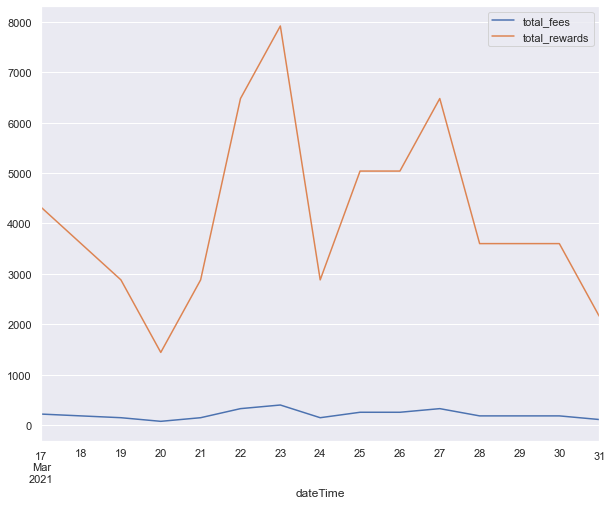

In [16]:
plot_df = df.set_index("dateTime", drop=False)
plot_df.resample("D").agg(
    {"total_fees": lambda x: x.sum() / 1e9, "total_rewards": lambda x: x.sum() / 1e9}
).plot()

<AxesSubplot:xlabel='dateTime'>

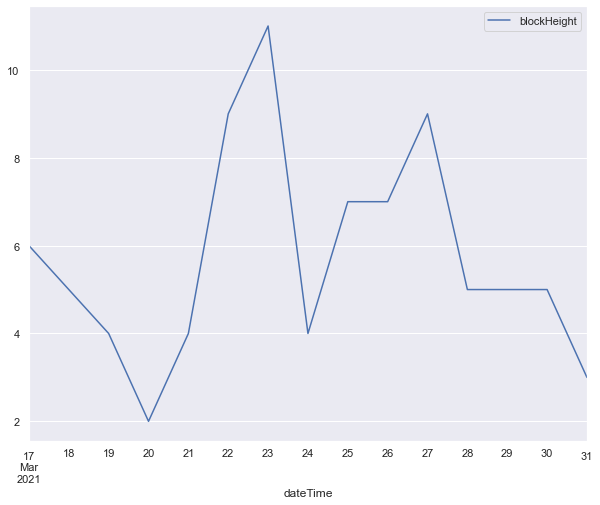

In [17]:
plot_df.resample("D").agg({"blockHeight": "count"}).plot()

## payouts

In [18]:
merged_df = df.merge(stakes_df, how='cross')

In [19]:
# make this nicer
foundation_df = merged_df[merged_df.is_foundation_delegation == True]
non_foundation_df = merged_df[merged_df.is_foundation_delegation == False]

### foundation

In [20]:
foundation_df.loc[:, "payout"] = (
    (foundation_df.balance / total_staking_balance)
    * foundation_df.transactions_coinbase
    * (1 - STAKER_FOUNDATION_FEE)
)

foundation_block_to_total_rewards_dict = (
    foundation_df.groupby(["blockHeight"])["payout"].sum().to_dict()
)

# payouts to foundation in mina
foundation_payout_df = foundation_df.groupby("public_key")["payout"].sum().to_frame()
foundation_payout_df / 1e9

,payout
public_key,
B62qmQAFPta1Q3c7wXHxXRKnE3uWyBYZCLb8frdHEgavi3BbBVkpeC1,2717.534961
B62qmsYXFNNE565yv7bEMPsPnpRCsMErf7J2v5jMnuKQ1jgwZS8BzXS,9156.036394
B62qn71s63yywMUCcFhP4iCata7HpgyrvmGjpKa1D9544vGW6FBZ6a1,4869.799366
B62qqEV4oP7w2jLQGckvZzdWjfdLKySKHJ3tNU5niRjpPD7beYumWTB,3285.750670


# non foundation

In [21]:
non_foundation_df.loc[:, "supercharged_contribution"] = (
    (non_foundation_df.supercharged_weighting - 1)
    * non_foundation_df.timing_timed_weighting
) + 1

non_foundation_df.loc[:, "effective_stake"] = (
    non_foundation_df.balance * non_foundation_df.supercharged_contribution
)

In [22]:
weights_dict = (
    non_foundation_df.groupby(["blockHeight", "public_key"])["effective_stake"].sum()
    / non_foundation_df.groupby("blockHeight")["effective_stake"].sum()
).to_dict()


def get_block_total(row):
    block_height = row["blockHeight"]
    public_key = row["public_key"]

    w = weights_dict[(block_height, public_key)]

    block_total_rewards = block_height_to_total_rewards_dict[block_height]
    foundation_payouts = foundation_block_to_total_rewards_dict.get(block_height, 0)
    block_pool_share = block_total_rewards - (
        foundation_payouts / (1 - STAKER_FOUNDATION_FEE)
    )

    return block_pool_share * w * (1.0 - STAKER_FEE)


non_foundation_df["payout"] = non_foundation_df.apply(
    lambda row: get_block_total(row), axis=1
)

In [23]:
# payouts to foundation in mina
non_foundation_payout_df = (
    non_foundation_df.groupby("public_key")["payout"].sum().to_frame().astype(int)
)
non_foundation_payout_df.head() / 1e9

,payout
public_key,
B62qiWSe63weqBN3vpnUyagnMkYmvRwKKQJ4dKckuJFsojUAYY56mfx,356.745540
B62qiX7wCtUbpzgJavPKbfBcLJ6nyYB88cWjfwjWZiyZZLS7weCDxwm,1097.550174
B62qid7mcNh29WVifR2qWQDLJ9dRu94EUcbsgrTr9fdFMGsPQzWv8Qo,356.745540
B62qieizHWA2zusWh8y9eCzqA6dvgGNSs5RJGHPmAGcBtdgr8BRSfEg,356.745540
B62qikygSmv245hJZQzAhAqxfqeNiyPDZUS9MME4HkP9oFNhij85XUp,356.745540


In [24]:
payout_df = pd.concat([foundation_payout_df, non_foundation_payout_df]).sort_values(
    by="payout", ascending=False
) / 1e9
payout_df['is_foundation'] = payout_df.index.isin(FOUNDATION_DELEGATION_ADDRESSES)
payout_df.head(n=10)

,payout,is_foundation
public_key,,
B62qmsYXFNNE565yv7bEMPsPnpRCsMErf7J2v5jMnuKQ1jgwZS8BzXS,9156.036394,True
B62qn71s63yywMUCcFhP4iCata7HpgyrvmGjpKa1D9544vGW6FBZ6a1,4869.799366,True
B62qqEV4oP7w2jLQGckvZzdWjfdLKySKHJ3tNU5niRjpPD7beYumWTB,3285.750670,True
B62qmQAFPta1Q3c7wXHxXRKnE3uWyBYZCLb8frdHEgavi3BbBVkpeC1,2717.534961,True
B62qoUiAHZZ9xY7BibT84iwMtgQidQByE7tCuNhn6DmyKhUPAzpnJAd,1658.450105,False
B62qrQMPSJpee1NnxVb4cr1qBtH3kMNpXaHVj4oVxNhqadCMBk6wELy,1658.450105,False
B62qiX7wCtUbpzgJavPKbfBcLJ6nyYB88cWjfwjWZiyZZLS7weCDxwm,1097.550174,False
B62qouqyiJfmysbVqgXZJy7rDvh2ZT1w5vmEQXqKAkpfvk37xQePyYL,1097.550174,False
B62qowpMhZ2Ww7b8xQxcK7rrpfsL5Nt5Yz5uxaizUBKqpeZUqBETa31,356.745540,False


### play

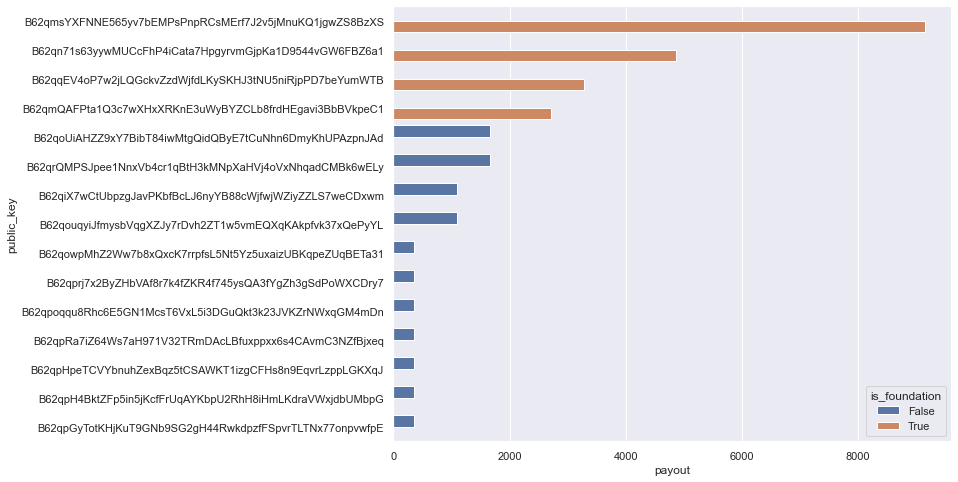

In [25]:
plot_df = payout_df.head(n=15) 
ax = sns.barplot(
    x="payout", y=plot_df.index, data=plot_df, orient="h", hue="is_foundation"
)

### luck/performance

In [26]:
slots_per_epoch = 7140

def get_slot_win_perc(stake, total_currency):
    return (1 - ((1 / 4) ** (stake / total_currency)))

In [27]:
# make this more precise
slot_win_pct = get_slot_win_perc(
    total_staking_balance, df.protocolState_consensusState_totalCurrency.mean() / 1e9
)
print(f"slot_win_pct: {slot_win_pct}")

slot_win_pct: 0.018526292667700894


In [28]:
expected_blocks_value = slot_win_pct * slots_per_epoch 
print(f"expected blocks: {expected_blocks_value}")

expected blocks: 132.27772964738438


In [29]:
# theory
binom(slots_per_epoch, slot_win_pct).expect()

132.2777296466144

In [30]:
# canonical + non-canonical
all_won_blocks = blocks_df.blockHeight.nunique()
print(f"all_won_blocks: {all_won_blocks}")

all_won_blocks: 144


In [31]:
# simulation
data = binom.rvs(n=slots_per_epoch, p=slot_win_pct, size=100000)

k = np.arange(int(expected_blocks_value - 50), int(expected_blocks_value) + 50, 1)

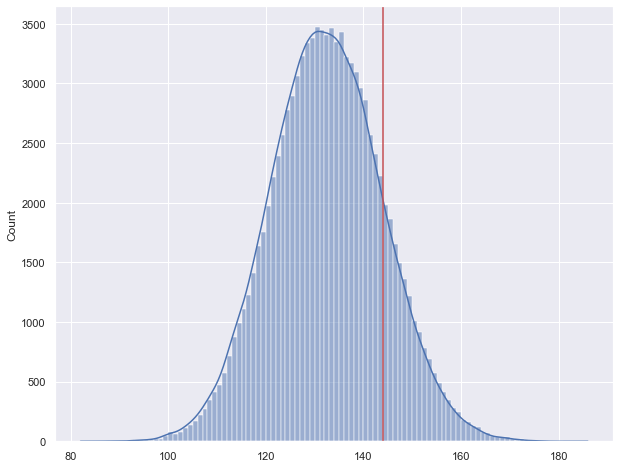

In [32]:
sns.histplot(data, kde=True, bins=k)
plt.axvline(blocks_df.blockHeight.nunique(), 0, 1, color="r")